In [1]:
# The basics
%matplotlib inline
import matplotlib.pyplot as plt
import time
import itertools
import matplotlib
import pickle
import pandas as pd

import numpy as np
import sys
import os
import collections
from collections import namedtuple

import gym

# Let's import basic tools for defining the function and doing the gradient-based learning
import sklearn.pipeline
import sklearn.preprocessing
#from sklearn.preprocessing import PolynomialFeatures # you can try with polynomial basis if you want (It is difficult!)
from sklearn.linear_model import SGDRegressor # this defines the SGD function
from sklearn.kernel_approximation import RBFSampler # this is the RBF function transformation method

from scipy.linalg import norm, pinv

#import environment
import sys
sys.path.append(r'../virl')
import virl

In [2]:

"""
Policy function
"""

def create_policy(func_approximator, epsilon, nA):
    
    def policy_fn(state):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = func_approximator.predict(state)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A,q_values  # return the potentially stochastic policy (which is due to the exploration)

    return policy_fn # return a handle to the function so we can call it in the future



"""
Execute the policy
"""
def exec_policy(env, func_approximator, verbose=False):

    # The policy is defined by our function approximator (of the utility)... let's get a hdnle to that function
    policy = create_policy(func_approximator, 0.0, env.action_space.n)
            
    # Reset the environment and pick the first action
    state = env.reset()
                    
    # One step in the environment
    for t in itertools.count():
        env.render()

        # The policy is stochastic due to exploration 
        # i.e. the policy recommends not only one action but defines a 
        # distrbution , \pi(a|s)
        pi_action_state, q_values = policy(state)
        action = np.random.choice(np.arange(len(pi_action_state)), p=pi_action_state)
        #print("Action (%s): %s" % (action_probs,action)

        # Execute action and observe where we end up incl reward
        next_state, reward, done, _ = env.step(action)
        
        if verbose:
            print("Step %d/199:\n" % (t), end="")
            print("\t state     : %s\n" % (state), end="")            
            print("\t q_approx  : %s\n" % (q_values.T), end="")
            print("\t pi(a|s)   : %s\n" % (pi_action_state), end="")            
            print("\t action    : %s\n" % (action), end="")
            print("\t next_state: %s\n" % (next_state), end="")
            print("\t reward    : %s\n" % (reward), end="")                        
        else:
            print("\rStep {}".format(t), end="")
       
        if done:
            break
            
        state = next_state
        
        
        
"""
Function Approximation
"""

class FunctionApproximator():
 
    def __init__(self, eta0= 0.01, learning_rate= "constant", read_approximator = None):
      
        self.eta0=eta0
        self.learning_rate=learning_rate
        
        self.models = []
        
        if read_approximator is None:
             for _ in range(env.action_space.n):

                model = SGDRegressor(learning_rate=learning_rate, tol=1e-5, max_iter=1e5, eta0=eta0)
            
                model.partial_fit([self.featurize_state(env.reset())], [0])
                self.models.append(model)
                
        else:
            for d in read_approximator:
                f = open(d, 'rb')
                model = pickle.load(f)
                self.models.append(model)
                f.close()
            
    
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        s_scaled = scaler.transform([state])
        s_transformed = feature_transformer.transform(s_scaled)
        return s_transformed[0]
    
    def predict(self, s, a=None):

        features = self.featurize_state(s)
        if a==None:
            return np.array([m.predict([features])[0] for m in self.models])
        else:            
            return self.models[a].predict([features])[0]
    
    def save_models(self, path):
        for index in range(len(path)):
            f = open(path[index], 'wb')
            pickle.dump(self.models[index], f)
            f.close()
            
    def update(self, s, a, td_target):
        """
        Updates the approximator's parameters (i.e. the weights) for a given state and action towards
        the target y (which is the TD target).
        """
        features = self.featurize_state(s)
        self.models[a].partial_fit([features], [td_target]) # recall that we have a seperate funciton for each a 
    
    def new_episode(self):        
        self.t_episode  = 0.  
        

        
        
"""
Reinforce learning
"""


def reinforce(env, func_approximator, num_episodes, epsilon=0.015, discount_factor=1.0, epsilon_decay=1.0):

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        policy = create_policy(
            func_approximator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step                                   
            action_probs, q_vals = policy(state)
            
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            
            ##
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")            

            if done:
                break
                
            state = next_state
    
        # Go through the episode, step-by-step and make policy updates (note we sometime use j for the individual steps)
        func_approximator.new_episode()
        new_theta=[]
        for t, transition in enumerate(episode):                 
            # The return, G_t, after this timestep; this is the target for the PolicyEstimator
            G_t = sum(discount_factor**i * t.reward for i, t in enumerate(episode[t:]))
           
            # Update our policy estimator
            func_approximator.update(transition.state, transition.action,np.array(G_t))            
         
    return stats




In [3]:
class save_stats():
    
    def __init__(self, stats):
        self.stats_length = stats.episode_lengths
        self.stats_reward = stats.episode_rewards
        
    

### Problem id = 0

In [22]:
# Load the file
env = virl.Epidemic(problem_id = 0, noisy = False)

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

feature_transformer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
feature_transformer.fit(scaler.transform(observation_examples))

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

my_func_approximator = FunctionApproximator()

In [23]:
stats = reinforce(env, my_func_approximator, 1500, discount_factor=0.99)

Step 51 @ Episode 1500/1500 (-1.6741660132029106)

In [24]:
save_stats_train = save_stats(stats)
file = open('./data0/stats_train', 'wb')
pickle.dump(save_stats_train, file)
file.close()

In [25]:
model_path = ['./data0/model0','./data0/model1', './data0/model2', './data0/model3']
my_func_approximator.save_models(model_path)


## Plot the figures

In [26]:
def plot_episode_stats(stats, smoothing_window):
    
    # Plot the episode reward over time
    
    fig1 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.grid(True)

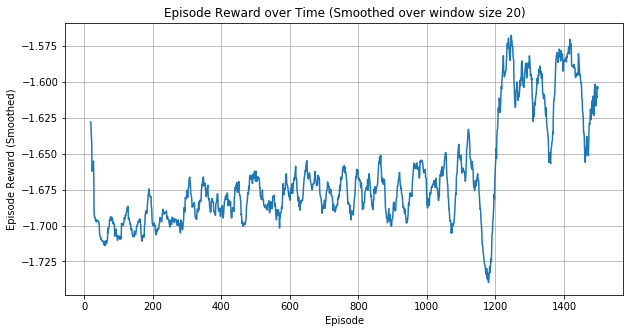

In [27]:
plot_episode_stats(stats, smoothing_window=20)

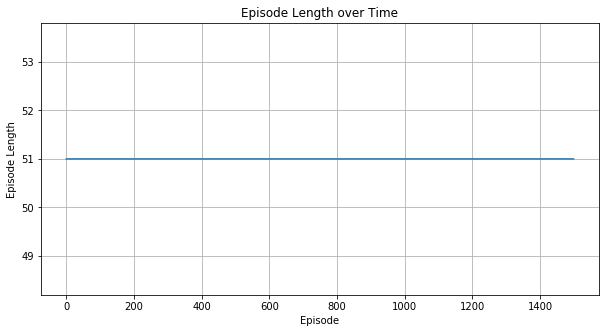

In [10]:
def plot_episode_stats(stats, smoothing_window):
    
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    plt.grid(True)
    
plot_episode_stats(stats, smoothing_window=1)

### Policy search: problem id = 1

In [11]:
# Load the file
env = virl.Epidemic(problem_id = 1, noisy = False)

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

feature_transformer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
feature_transformer.fit(scaler.transform(observation_examples))

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

my_func_approximator = FunctionApproximator()

stats = reinforce(env, my_func_approximator, 1500, discount_factor=0.99)

model_path = ['./data1/model0','./data1/model1', './data1/model2', './data1/model3']
my_func_approximator.save_models(model_path)

Step 51 @ Episode 1500/1500 (-0.3781055710051935))

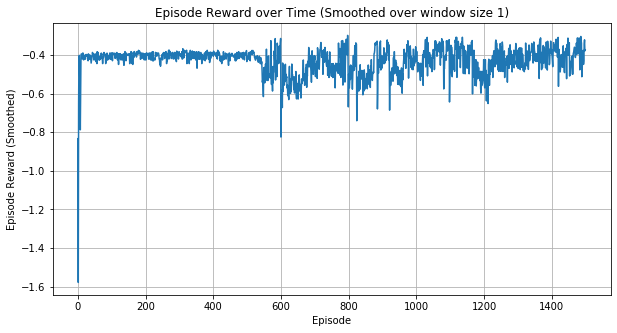

In [13]:
save_stats_train = save_stats(stats)
file = open('./data1/stats_train', 'wb')
pickle.dump(save_stats_train, file)
file.close()

def plot_episode_stats(stats, smoothing_window):
    
    # Plot the episode reward over time
    
    fig1 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.grid(True)
    

plot_episode_stats(stats, smoothing_window=1)

### Policy search: problem id = 2

Step 51 @ Episode 1500/1500 (-0.467706446535454)6)

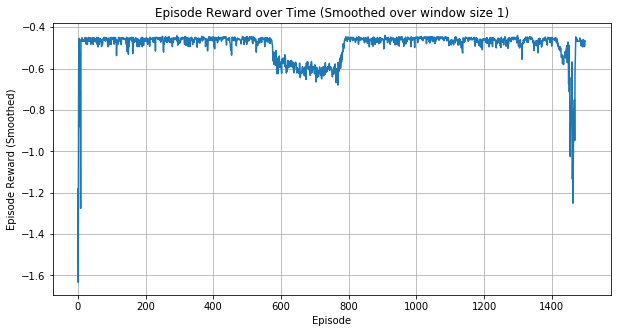

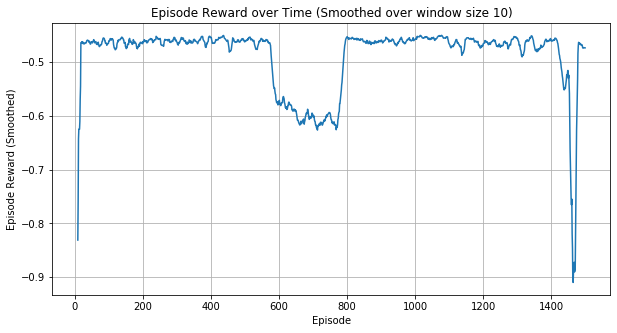

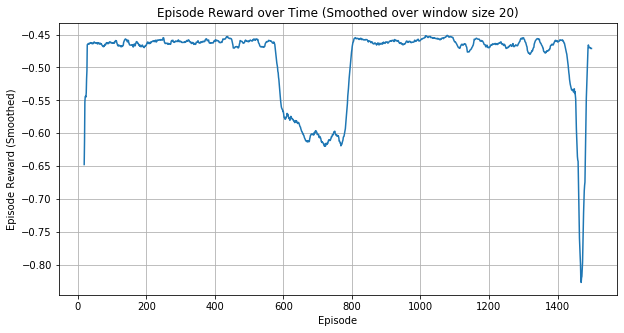

In [14]:
# Load the file
env = virl.Epidemic(problem_id = 2, noisy = False)

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

feature_transformer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
feature_transformer.fit(scaler.transform(observation_examples))

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

my_func_approximator = FunctionApproximator()

stats = reinforce(env, my_func_approximator, 1500, discount_factor=0.99)

save_stats_train = save_stats(stats)
file = open('./data2/stats_train', 'wb')
pickle.dump(save_stats_train, file)
file.close()

model_path = ['./data2/model0','./data2/model1', './data2/model2', './data2/model3']
my_func_approximator.save_models(model_path)



def plot_episode_stats(stats, smoothing_window):
    
    # Plot the episode reward over time
    
    fig1 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.grid(True)
    

plot_episode_stats(stats, smoothing_window=1)
plot_episode_stats(stats, smoothing_window=10)
plot_episode_stats(stats, smoothing_window=20)

### Policy search: problem id = 3

Step 51 @ Episode 1500/1500 (-0.6180522686185148)

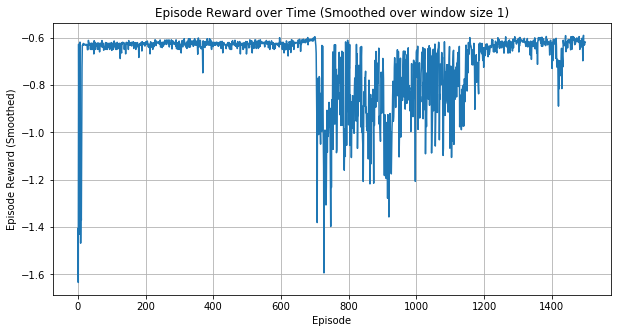

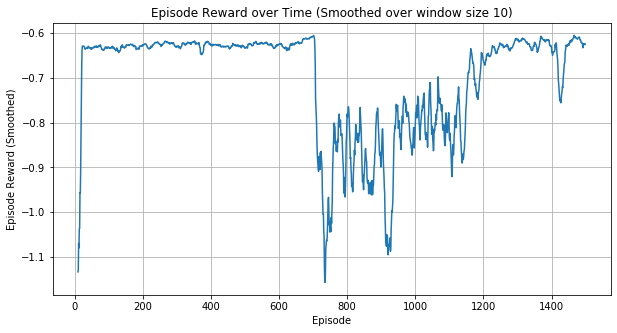

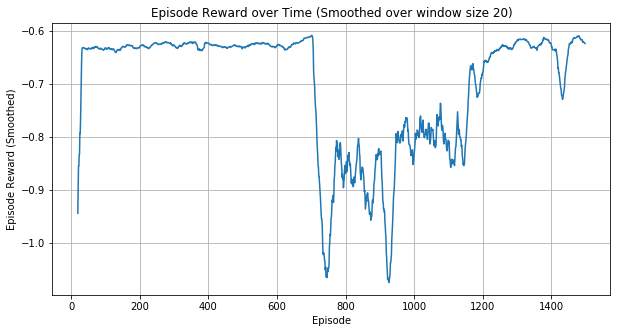

In [16]:
# Load the file
env = virl.Epidemic(problem_id = 3, noisy = False)

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

feature_transformer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
feature_transformer.fit(scaler.transform(observation_examples))

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

my_func_approximator = FunctionApproximator()

stats = reinforce(env, my_func_approximator, 1500, discount_factor=0.99)

save_stats_train = save_stats(stats)
file = open('./data3/stats_train', 'wb')
pickle.dump(save_stats_train, file)
file.close()

model_path = ['./data3/model0','./data3/model1', './data3/model2', './data3/model3']
my_func_approximator.save_models(model_path)



def plot_episode_stats(stats, smoothing_window):
    
    # Plot the episode reward over time
    
    fig1 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.grid(True)
    

plot_episode_stats(stats, smoothing_window=1)
plot_episode_stats(stats, smoothing_window=10)
plot_episode_stats(stats, smoothing_window=20)

### Policy search: problem id = 4

Step 51 @ Episode 1500/1500 (-1.33991941590947)3)

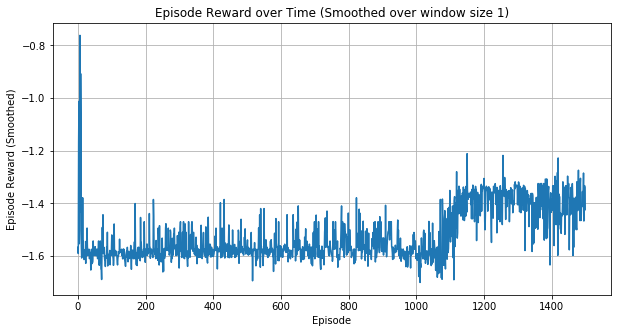

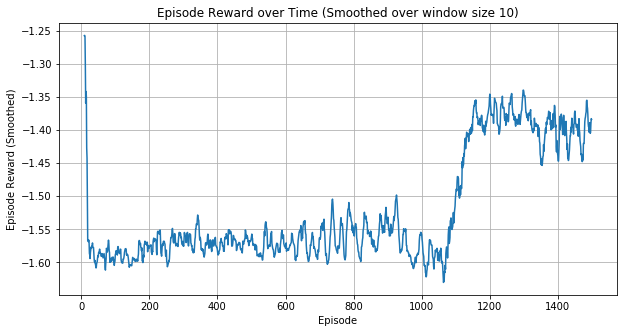

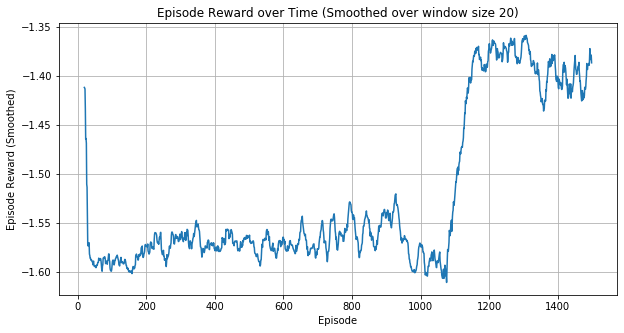

In [17]:
# Load the file
env = virl.Epidemic(problem_id = 4, noisy = False)

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

feature_transformer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
feature_transformer.fit(scaler.transform(observation_examples))

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

my_func_approximator = FunctionApproximator()

stats = reinforce(env, my_func_approximator, 1500, discount_factor=0.99)

save_stats_train = save_stats(stats)
file = open('./data4/stats_train', 'wb')
pickle.dump(save_stats_train, file)
file.close()

model_path = ['./data4/model0','./data4/model1', './data4/model2', './data4/model3']
my_func_approximator.save_models(model_path)

def plot_episode_stats(stats, smoothing_window):
    
    # Plot the episode reward over time
    
    fig1 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.grid(True)
    

plot_episode_stats(stats, smoothing_window=1)
plot_episode_stats(stats, smoothing_window=10)
plot_episode_stats(stats, smoothing_window=20)

### Policy search: problem id = 5

Step 51 @ Episode 1500/1500 (-1.8012287364279156)

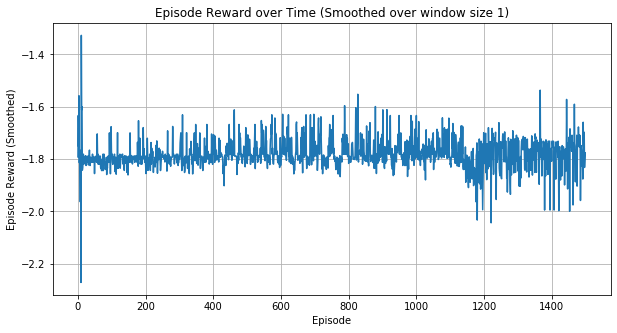

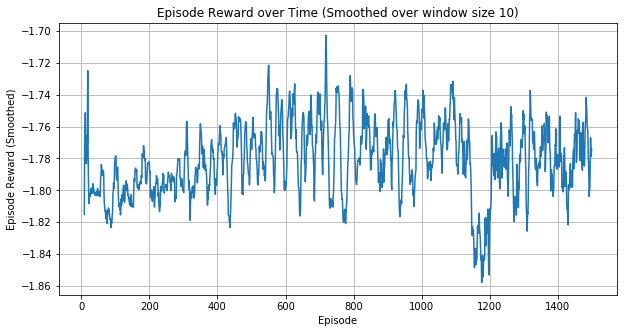

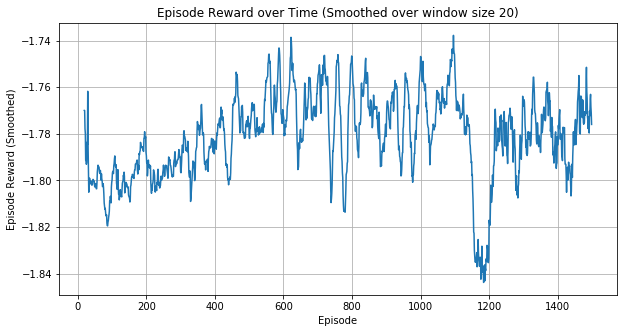

In [18]:
# Load the file
env = virl.Epidemic(problem_id = 5, noisy = False)

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

feature_transformer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
feature_transformer.fit(scaler.transform(observation_examples))

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

my_func_approximator = FunctionApproximator()

stats = reinforce(env, my_func_approximator, 1500, discount_factor=0.99)

save_stats_train = save_stats(stats)
file = open('./data5/stats_train', 'wb')
pickle.dump(save_stats_train, file)
file.close()

model_path = ['./data5/model0','./data5/model1', './data5/model2', './data5/model3']
my_func_approximator.save_models(model_path)

def plot_episode_stats(stats, smoothing_window):
    
    # Plot the episode reward over time
    
    fig1 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.grid(True)
    

plot_episode_stats(stats, smoothing_window=1)
plot_episode_stats(stats, smoothing_window=10)
plot_episode_stats(stats, smoothing_window=20)

### Policy Search: problem id = 6

Step 51 @ Episode 1500/1500 (-1.8822094191973606)

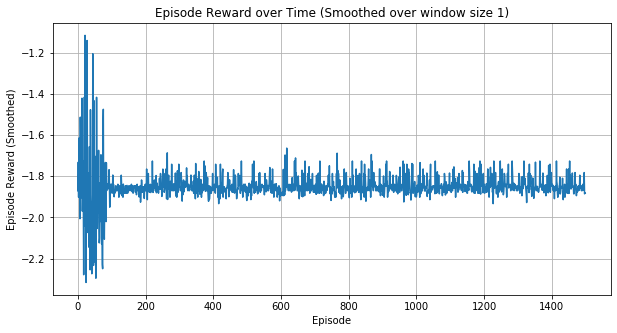

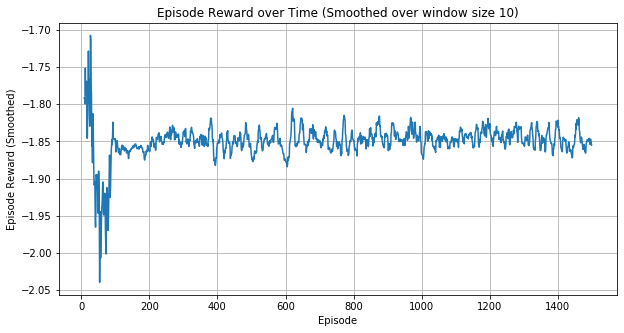

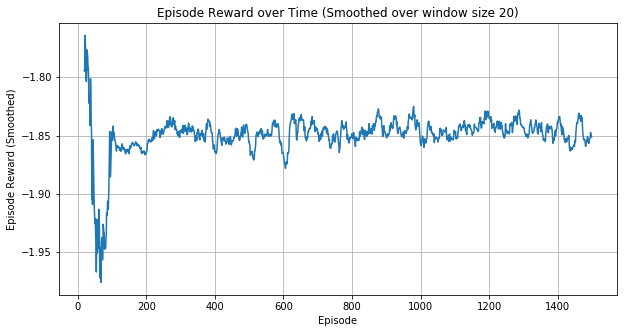

In [19]:
# Load the file
env = virl.Epidemic(problem_id = 6, noisy = False)

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

feature_transformer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
feature_transformer.fit(scaler.transform(observation_examples))

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

my_func_approximator = FunctionApproximator(eta0 = 0.001)

stats = reinforce(env, my_func_approximator, 1500, discount_factor=0.99)

save_stats_train = save_stats(stats)
file = open('./data6/stats_train', 'wb')
pickle.dump(save_stats_train, file)
file.close()

model_path = ['./data6/model0','./data6/model1', './data6/model2', './data6/model3']
my_func_approximator.save_models(model_path)

def plot_episode_stats(stats, smoothing_window):
    
    # Plot the episode reward over time
    
    fig1 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.grid(True)
    

plot_episode_stats(stats, smoothing_window=1)
plot_episode_stats(stats, smoothing_window=10)
plot_episode_stats(stats, smoothing_window=20)

### Policy Search: problem id = 7

Step 51 @ Episode 1500/1500 (-1.8268862358208162)

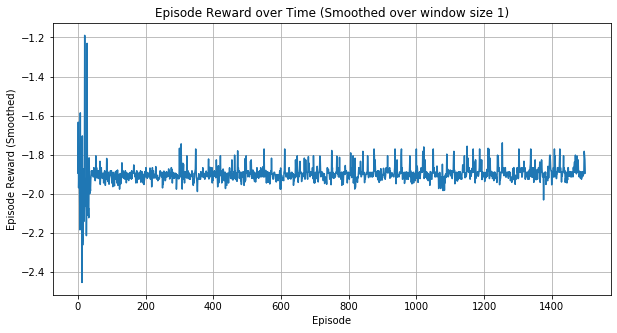

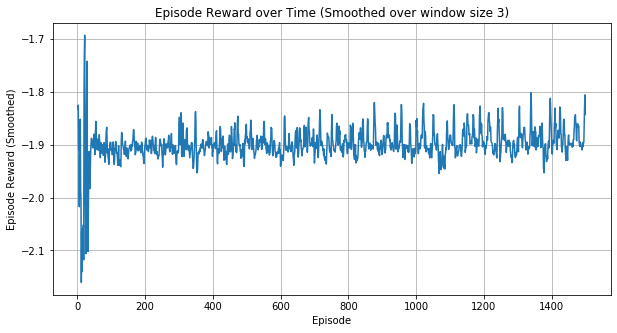

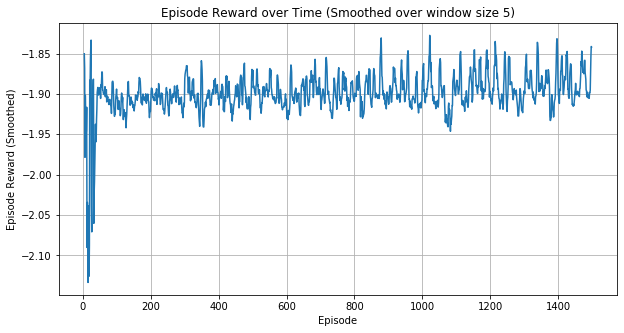

In [20]:
# Load the file
env = virl.Epidemic(problem_id = 7, noisy = False)

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

feature_transformer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
feature_transformer.fit(scaler.transform(observation_examples))

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

my_func_approximator = FunctionApproximator(eta0 = 0.002)

stats = reinforce(env, my_func_approximator, 1500, discount_factor=0.99)

save_stats_train = save_stats(stats)
file = open('./data7/stats_train', 'wb')
pickle.dump(save_stats_train, file)
file.close()

model_path = ['./data7/model0','./data7/model1', './data7/model2', './data7/model3']
my_func_approximator.save_models(model_path)

def plot_episode_stats(stats, smoothing_window):
    
    # Plot the episode reward over time
    
    fig1 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.grid(True)
    

plot_episode_stats(stats, smoothing_window=1)
plot_episode_stats(stats, smoothing_window=3)
plot_episode_stats(stats, smoothing_window=5)

### Policy Search: problem id = 8

Step 51 @ Episode 1500/1500 (-1.8435949811905377)

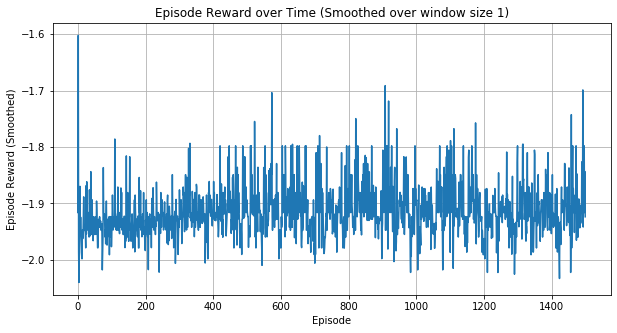

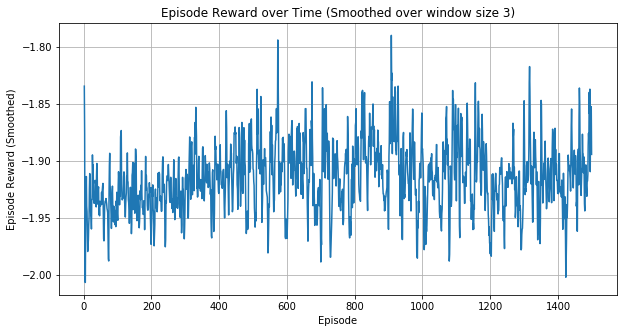

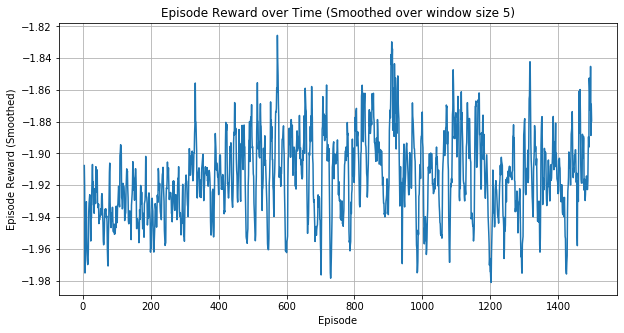

In [21]:
# Load the file
env = virl.Epidemic(problem_id = 8, noisy = False)

observation_examples = np.array([env.observation_space.sample() for x in range(10000)])

scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

feature_transformer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
feature_transformer.fit(scaler.transform(observation_examples))

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

my_func_approximator = FunctionApproximator()

stats = reinforce(env, my_func_approximator, 1500, discount_factor=0.99)

save_stats_train = save_stats(stats)
file = open('./data8/stats_train', 'wb')
pickle.dump(save_stats_train, file)
file.close()

model_path = ['./data8/model0','./data8/model1', './data8/model2', './data8/model3']
my_func_approximator.save_models(model_path)

def plot_episode_stats(stats, smoothing_window):
    
    # Plot the episode reward over time
    
    fig1 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.grid(True)
    

plot_episode_stats(stats, smoothing_window=1)
plot_episode_stats(stats, smoothing_window=3)
plot_episode_stats(stats, smoothing_window=5)